In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import flow.visualize.visualize_ring as visualize_ring

import torch
print(torch.__version__)

# Anti-Flow specific functions for  detection:
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

print('Libraries loaded.')

1.7.1
Libraries loaded.


# Setting up ring-road simulations:

In [11]:
import utils
reload(utils)
from utils import run_ring_sim_variable_cfm

In [10]:
import Adversaries.controllers
reload(Adversaries.controllers)
from Adversaries.controllers.base_controller import BaseController


class Bando_OVM_FTL(BaseController):
    def __init__(self,
                 veh_id,
                 car_following_params,
                 delay=0.0,
                 noise=0.0,
                 fail_safe=None,
                 a=0.8,
                 b=20.0,
                 s0=1.0,
                 s1=2.0,
                 Vm=15.0):
        #Inherit the base controller:
        BaseController.__init__(
            self,
            veh_id,
            car_following_params,
            delay=delay,
            fail_safe=fail_safe,
            noise=noise)
        
        # Model parameters, which can be changed at initialization:
        self.Vm = Vm
        self.s0 = s0
        self.s1 = s1
        self.a = a
        self.b = b
        
    def get_accel(self, env):
        """This function is queried during simulation
           to acquire an acceleration value:"""
        # env contains all information on the simulation, and 
        # can be queried to get the state of different vehicles.
        # We assume this vehicle has access only to its own state,
        # and the position/speed of the vehicle ahead of it. 
        lead_id = env.k.vehicle.get_leader(self.veh_id) #Who is the leader
        v_l = env.k.vehicle.get_speed(lead_id) #Leader speed
        v = env.k.vehicle.get_speed(self.veh_id) #vehicle's own speed
        s = env.k.vehicle.get_headway(self.veh_id) #inter-vehicle spacing to leader

        # We build this model off the popular Bando OV-FTL model:
        v_opt = self.OV(s)
        ftl = self.FTL(v,v_l,s)
        u = self.a*(v_opt-v) + self.b*ftl
        
        return u #return the acceleration that is set above.
        
    def get_custom_accel(self, v, v_l, s):
        """This function can be queried at any time,
           and is useful for analyzing controller
           behavior outside of a sim."""
        v_opt = self.OV(s)
        ftl = self.FTL(v,v_l,s)
        u = self.a*(v_opt-v) + self.b*ftl
        return u
    
    def OV(self,s):
        return self.Vm*((np.tanh(s/self.s0-self.s1)+np.tanh(self.s1))/(1+np.tanh(self.s1)))
    
    def FTL(self,v,v_l,s):
        return (v_l-v)/(s**2)
    
print('Bando OVM-FTL model initialized.')

Non adversarial CFM initiialized.


In [52]:
#Run with just one class of driver:
driver_controller_list = []
num_drivers = 20

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label,cfm_controller,num_drivers])
print('Simulation params initialized.')
print(driver_controller_list)

Simulation params initialized.
[['bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0', (<class '__main__.Bando_OVM_FTL'>, {'a': 0.8, 'b': 20.0, 's0': 1.0, 's1': 2.0, 'Vm': 15.0, 'noise': 0.1}), 20]]


In [53]:
import utils
reload(utils)
sim_res_list_1_class = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list,sim_time=1000)

Number unique drivers: 1
Running ring simulation, ring length: 300
Round 0, return: 7345.014909569155
data/ring_variable_cfm_20220101-1731111641076271.42885-0_emission.csv data
Average, std returns: 7345.014909569155, 0.0
Average, std velocities: 8.269617345360238, 0.0
Average, std outflows: 0.0, 0.0
Total time: 68.9988181591034
steps/second: 168.60931449652455


Data loaded.


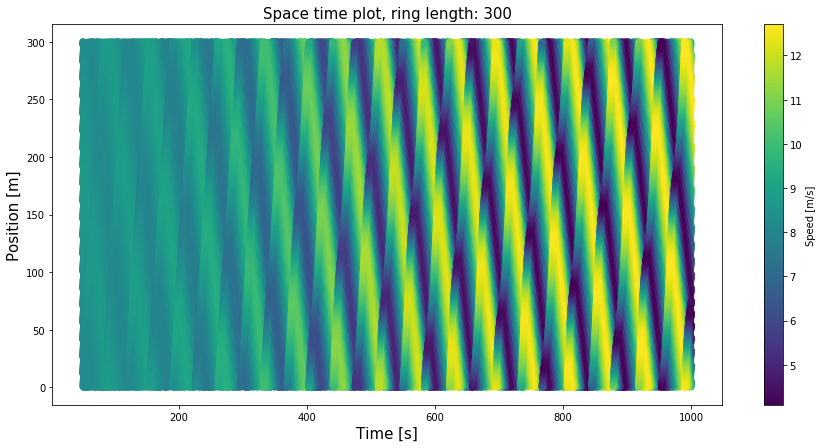

In [54]:
import os
emission_path = os.path.join(os.getcwd(),sim_res_list_1_class[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_path)

In [55]:
timeseries_dict_1_class = visualize_ring.get_sim_timeseries(csv_path = emission_path)

Data loaded.


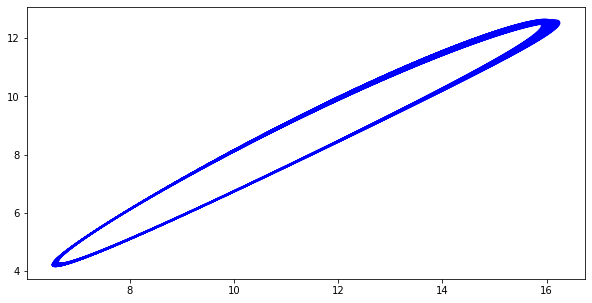

In [56]:
import matplotlib.pyplot as plt

begin_time = 700.0
end_time = 800.0

veh_ids = (timeseries_dict_1_class.keys())
plt.figure(figsize=[10,5])
for veh_id in veh_ids:
    time = timeseries_dict_1_class[veh_id][:,0]
    index_select = np.logical_and(time>begin_time,time<end_time)
    
    
    speed = timeseries_dict_1_class[veh_id][:,1]
    spacing = timeseries_dict_1_class[veh_id][:,2]
    
    speed = speed[index_select]
    spacing = spacing[index_select]
    
    plt.plot(spacing,speed,'b')

In [18]:
#Run with two classes of driver:
driver_controller_list = []
num_drivers = 10

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label,cfm_controller,num_drivers])

a=0.2
b=10.0
s0=1.0
s1=3.0
Vm=13.0

label = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label,cfm_controller,num_drivers])


print('Simulation params initialized: ')
print(driver_controller_list)

Simulation params initialized: 
[['bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0', (<class '__main__.Bando_OVM_FTL'>, {'a': 0.8, 'b': 20.0, 's0': 1.0, 's1': 2.0, 'Vm': 15.0, 'noise': 0.1}), 10], ['bando_ftl_ovm_a0.2_b10.0_s01.0_s13.0_Vm13.0', (<class '__main__.Bando_OVM_FTL'>, {'a': 0.2, 'b': 10.0, 's0': 1.0, 's1': 3.0, 'Vm': 13.0, 'noise': 0.1}), 10]]


In [138]:
import utils
reload(utils)
sim_res_list_2_class = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list,sim_time=1000)

Number unique drivers: 2
Error during start: Traceback (most recent call last):
  File "/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/flow/core/kernel/simulation/traci.py", line 255, in start_simulation
    traci_connection.setOrder(0)
  File "/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/traci/connection.py", line 348, in setOrder
    self._sendExact()
  File "/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/traci/connection.py", line 99, in _sendExact
    raise FatalTraCIError("connection closed by SUMO")
traci.exceptions.FatalTraCIError: connection closed by SUMO

Error during teardown: [Errno 1] Operation not permitted
Error during start: Traceback (most recent call last):
  File "/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/flow/core/kernel/simulation/traci.py", line 255, in start_simulation
    traci_connection.setOrder(0)
  File "/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/traci/connection.py", line 348, in setOrder
    self._sendExact

FatalTraCIError: connection closed by SUMO

Data loaded.


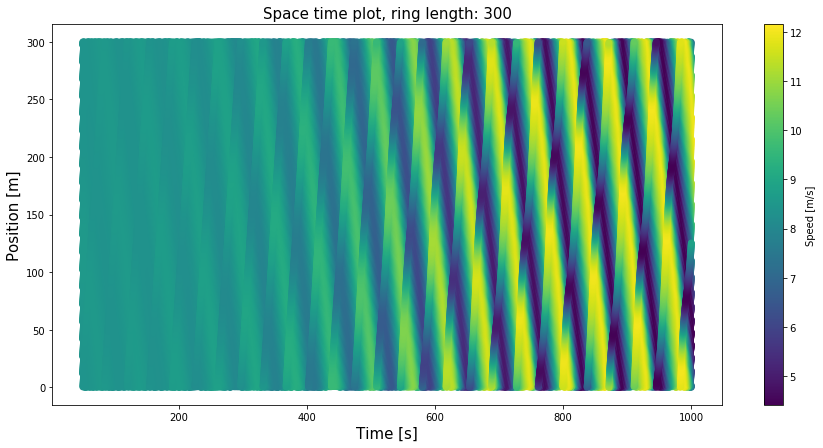

In [40]:
emission_path = os.path.join(os.getcwd(),sim_res_list_2_class[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_path)

In [58]:
emission_path = os.path.join(os.getcwd(),sim_res_list_2_class[1])
timeseries_dict_2_class = visualize_ring.get_sim_timeseries(csv_path = emission_path)

Data loaded.


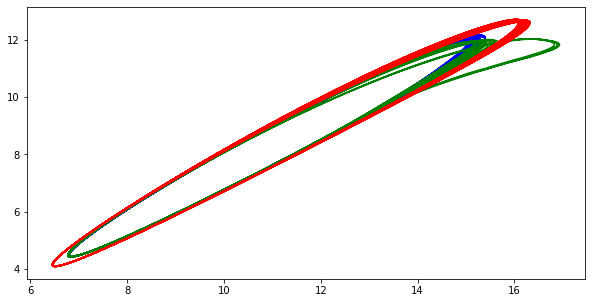

In [61]:
import matplotlib.pyplot as plt

begin_time = 900.0
end_time = 1000.0

label_1 = 'bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0'
label_2 = 'bando_ftl_ovm_a0.2_b10.0_s01.0_s13.0_Vm13.0'

veh_ids = (timeseries_dict_2_class.keys())
plt.figure(figsize=[10,5])
for veh_id in veh_ids:
    time = timeseries_dict[veh_id][:,0]
    index_select = np.logical_and(time>begin_time,time<end_time)
    
    speed = timeseries_dict[veh_id][:,1]
    spacing = timeseries_dict[veh_id][:,2]
    
    speed = speed[index_select]
    spacing = spacing[index_select]
    
    if(label_1 in veh_id):
        plt.plot(spacing,speed,'b')
    elif(label_2 in veh_id):
        plt.plot(spacing,speed,'g')

veh_ids = (timeseries_dict_1_class.keys())        
for veh_id in veh_ids:
    time = timeseries_dict_1_class[veh_id][:,0]
    index_select = np.logical_and(time>begin_time,time<end_time)
    
    speed = timeseries_dict_1_class[veh_id][:,1]
    spacing = timeseries_dict_1_class[veh_id][:,2]
    
    speed = speed[index_select]
    spacing = spacing[index_select]
    
    plt.plot(spacing,speed,'r')


# Experimentation with AutoEncoder below:

In [143]:
def get_ae_model(n_features=1,seq_len=100):
    #Network specific hyper-params:
    embedding_dim = 32
    cnn_channels = 8
    kernel_size = 16
    stride = 1
    batch_size = 16
    device = 'cpu' #Change to cuda if appropriate
    n_features=n_features #Number of features, in the case only 1: speed
    seq_len = 100 #How many samples from the time-series we look at per time

    #initialize the CNN LSTM AutoEncoder:
    model = CNNRecurrentAutoencoder(seq_len,
                                    n_features,
                                    embedding_dim,
                                    cnn_channels, 
                                    kernel_size, 
                                    stride, 
                                    device)
    return model
    

In [83]:
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data
import datetime
def train_model(model,train_X,model_file_name,n_epoch=150):
    embedding_dim = 32
    cnn_channels = 8
    kernel_size = 16
    stride = 1
    batch_size = 16
    device = 'cpu'

    save_path=os.path.join(os.getcwd(),'models/')

    trainset = SeqDataset(train_X)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    np.savez(f'{save_path}cnn_lstm_ae_{model_file_name}.npz', seq_len=seq_len, embedding_dim=embedding_dim,
             cnn_channels=cnn_channels, kernel_size=kernel_size, stride=stride)

    SAVE_PATH = f'{save_path}cnn_lstm_ae_{model_file_name}.pt'

    do_load = False
    if do_load and os.path.exists(SAVE_PATH):
        model.load_state_dict(torch.load(SAVE_PATH))

    if not do_load:
        best_loss = 999999
    else:
        train_ls, train_tot = eval_data(model=model, dataloader=trainloader)
        best_loss = 1.0 * train_ls/train_tot

    for e in range(n_epoch):
        l = train_epoch(model=model, optimizer=optimizer, dataloader=trainloader)
        train_ls, train_tot = eval_data(model=model, dataloader=trainloader)
        avg_loss = 1.0 * train_ls / train_tot
        if e % 10 == 0:
            print("Epoch %d, total loss %f, total predictions %d, avg loss %f" % (e, train_ls, train_tot, avg_loss),
                  datetime.datetime.now())
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), SAVE_PATH)
            print("Saving model. Best loss: "+str(best_loss))

    return model

In [80]:
save_path=os.path.join(os.getcwd(),'models/')
print(save_path)
print(os.getcwd())

/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/detector_dev/models/
/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/detector_dev


In [63]:
#Deep learning-based detection. Start with just speed

#initialize the CNN LSTM AutoEncoder:
model_1_class_speed = get_ae_model()
print('Model initialized.')

Model initialized.


In [139]:
#Reflects the training scenario:
model_file_name = 'bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0_20veh_300ring_speed_detector'

num_samples_per_veh = 100
seq_len = 100
training_data_list = []
for veh_id in timeseries_dict_1_class:
    data = timeseries_dict_1_class[veh_id]
    speed = data[:,1]
    sample_length = len(speed)
    
    sample_start_points = np.random.randint(sample_length-seq_len,
                                            size=num_samples_per_veh)
    for i in range(num_samples_per_veh):
        start = sample_start_points[i]
        end = start+seq_len
        training_data_list.append(speed[start:end])
    
train_X = torch.Tensor(np.array(training_data_list))

print('Training set created:'+str(train_X.shape))

Training set created:torch.Size([2000, 100])


In [142]:
trainset = SeqDataset(train_X)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=False)
optimizer = torch.optim.Adam(model_1_class_speed.parameters(), lr=1e-3, weight_decay=1e-5)

dataloader = trainloader

model_1_class_speed.train()

cum_loss = 0.0
tot_num = 0.0
for X, y in dataloader:
    optimizer.zero_grad()
    B = X.shape[0]
    if(X.shape[2] != 1):
        flat_pred = flatten_preds(pred)
        flat_X = X.reshape(flat_pred.shape)
        loss = model_1_class_speed.loss(flat_pred,flat_X)
    else:
        X_float = X.float()
        print(X_float.shape)
        
        pred = model_1_class_speed(X.float())
        loss = model_1_class_speed.loss(pred, X)

    loss = torch.sum(loss)
    loss.backward()
    optimizer.step()

    # cum_loss += loss.item()
    cum_loss += loss.detach().cpu().numpy()
    # pred_c = pred.max(1)[1].cpu()
    tot_num = tot_num + B
    
print(cum_loss)
print(tot_num)

torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])
torch.Size([16, 100, 1])


In [84]:
#Train the model:
import time
print('Beginning training...')
begin_time = time.time()

model_1_class_speed = train_model(model_1_class_speed,
                                  train_X,
                                  model_file_name,
                                  n_epoch=150)
finish_time = time.time()
print('Finished training, total time: '+str(finish_time-begin_time))

Beginning training...
Epoch 0, total loss 26041.663712, total predictions 2000, avg loss 13.020832 2022-01-03 11:20:31.658971
Saving model. Best loss: 13.020831855773926
Saving model. Best loss: 12.578993041992188
Saving model. Best loss: 12.467497051239013
Saving model. Best loss: 12.395475662231446
Saving model. Best loss: 12.217910396575927
Saving model. Best loss: 11.806473114013672
Saving model. Best loss: 11.385755374908447
Saving model. Best loss: 9.524862365722656
Saving model. Best loss: 8.291721279144287
Saving model. Best loss: 4.738505390167236
Epoch 10, total loss 5215.868805, total predictions 2000, avg loss 2.607934 2022-01-03 11:21:48.823592
Saving model. Best loss: 2.6079344024658204
Saving model. Best loss: 2.4773222694396972
Saving model. Best loss: 2.2465303649902344
Saving model. Best loss: 1.9520943098068237
Saving model. Best loss: 1.3227376799583435
Saving model. Best loss: 1.2069783248901367
Epoch 20, total loss 2376.853874, total predictions 2000, avg loss 1.1

# Plot losses in spacetime:

In [108]:
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth

import time as time
import sys

def get_smoothed_losses(ae_model,emission_path,timeseries_dict=None):
    
    if(timeseries_dict is None):
        timeseries_dict = visualize_ring.get_sim_timeseries(csv_path = emission_path)
    
    i = 0
#     per_sample_computer_time = time.time()

    losses = []
    for veh_id in timeseries_dict:
        speed = timeseries_dict[veh_id][:,1]
        p,l = sliding_window(ae_model,speed)
        losses.append(l)
        i += 1
        sys.stdout.write('\r'+'Vehicle, '+str(i))
# #         sys.stdout.write('\r'+'Vehicle, '+str(i)+' compute time: '+str(time.time()-per_sample_computer_time))
#         per_sample_computer_time = time.time()

    #veh ids for all vehicles in the flow:
    veh_ids = list(timeseries_dict.keys())
    #A dictionary which holds smoothed losses for vehicles:
    smoothed_losses = dict.fromkeys(veh_ids)
    time = timeseries_dict[veh_ids[0]][:,0]
    #Get smoothed loss values:
    for i in range(len(losses)):
        loss = losses[i]
        smoothed_losses[veh_ids[i]] =  loss_smooth(time,loss)
    
    print('\nReturning smoothed losses.')
    
    return smoothed_losses


In [109]:
smoothed_losses_1_class = get_smoothed_losses(model_1_class_speed,
                                              emission_path_1_class,
                                              timeseries_dict_1_class)

Vehicle, 20
Returning smoothed losses.


Data loaded.


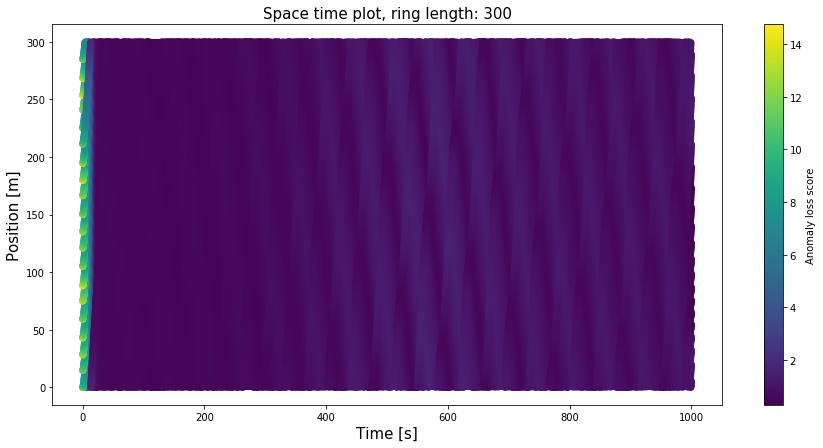

In [113]:
full_sim_data_dict_1_class = visualize_ring.get_sim_data_dict_ring(csv_path = emission_path_1_class,warmup_period=0.0)

#Create the spacetime plot:
visualize_ring.make_ring_spacetime_fig_with_losses(smoothed_losses_1_class,
                                                   sim_data_dict=full_sim_data_dict_1_class,
                                                   ring_length=300)
  

In [115]:
emission_path_2_class = os.path.join(os.getcwd(),sim_res_list_2_class[1])

smoothed_losses_2_class = get_smoothed_losses(model_1_class_speed,
                                              emission_path_2_class,
                                              timeseries_dict_2_class)

full_sim_data_dict_2_class = visualize_ring.get_sim_data_dict_ring(csv_path = emission_path_2_class,warmup_period=0.0)

Vehicle, 20
Returning smoothed losses.
Data loaded.


Data loaded.


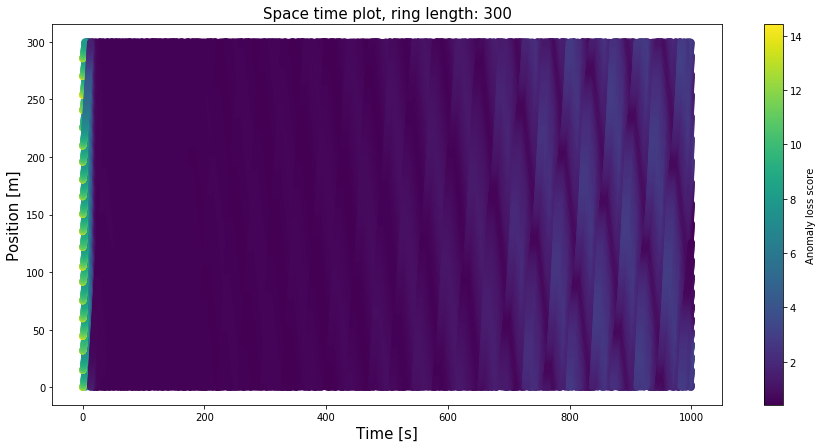

In [117]:
#Create the spacetime plot:
visualize_ring.make_ring_spacetime_fig_with_losses(smoothed_losses_2_class,
                                                   sim_data_dict=full_sim_data_dict_2_class,
                                                   ring_length=300)
  

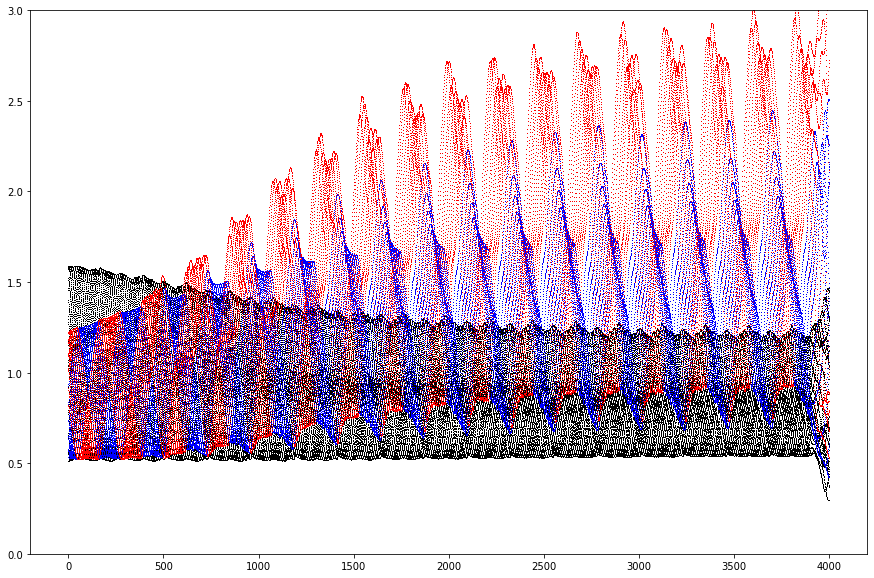

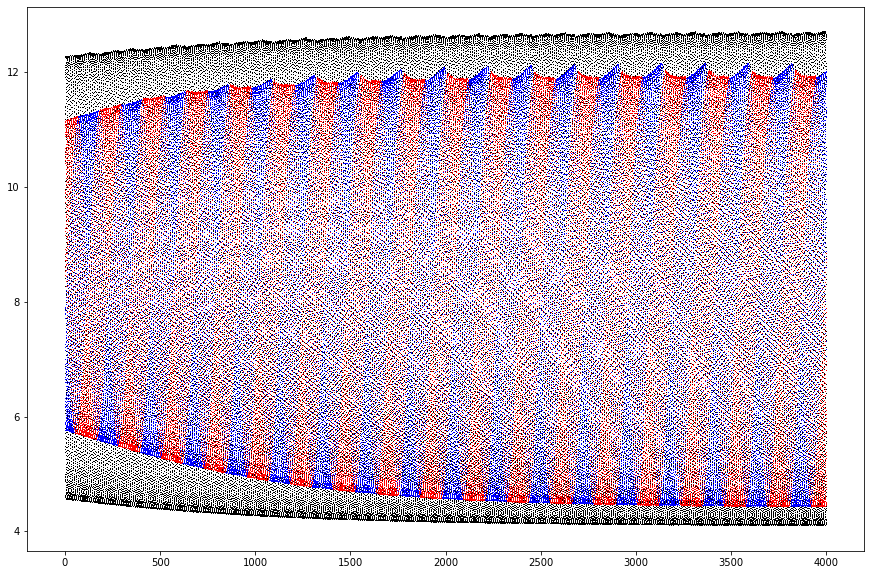

In [128]:
label_1 = 'bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0'
label_2 = 'bando_ftl_ovm_a0.2_b10.0_s01.0_s13.0_Vm13.0'
begin = 6000

plt.figure(figsize=[15,10])
# plt.subplot(2,1,1)
for veh_id in smoothed_losses_1_class:
    plt.plot(smoothed_losses_1_class[veh_id][begin:],'k,')
# plt.ylim([0,3.0])
# plt.subplot(2,1,2)
for veh_id in smoothed_losses_2_class:
    if(label_1 in veh_id):
        plt.plot(smoothed_losses_2_class[veh_id][begin:],'b,')
    else:
        plt.plot(smoothed_losses_2_class[veh_id][begin:],'r,')   
plt.ylim([0,3.0])


plt.figure(figsize=[15,10])
for veh_id in timeseries_dict_1_class:
    speed = timeseries_dict_1_class[veh_id][:,1]
    plt.plot(speed[begin:],'k,')
for veh_id in timeseries_dict_2_class:
    speed = timeseries_dict_2_class[veh_id][:,1]
    if(label_1 in veh_id):
        plt.plot(speed[begin:],'b,')
    else:
        plt.plot(speed[begin:],'r,') 



In [133]:
import Adversaries.controllers.car_following_adversarial
from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact

#Run with two classes of driver:
driver_controller_list = []
num_drivers = 19

a=0.8
b=20.0
s0=1.0
s1=2.0
Vm=15.0

label_1 = 'bando_ftl_ovm_a'+str(a)+'_b'+str(b)+'_s0'+str(s0)+'_s1'+str(s1)+'_Vm'+str(Vm)
cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
driver_controller_list.append([label,cfm_controller,num_drivers])

v_des = 10.0
braking_period = 5.0
braking_rate = -2.0

label_adv = 'FStop_vd'+str(v_des)+'_bperiod'+str(braking_period)+'_brate'+str(braking_rate)
cfm_controller = (FollowerStopper_Overreact,{})
driver_controller_list.append([label,cfm_controller,1])

print('Simulation params initialized: ')
print(driver_controller_list)

Simulation params initialized: 
[['bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0', (<class '__main__.Bando_OVM_FTL'>, {'a': 0.8, 'b': 20.0, 's0': 1.0, 's1': 2.0, 'Vm': 15.0, 'noise': 0.1}), 19], ['bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0', (<class 'Adversaries.controllers.car_following_adversarial.FollowerStopper_Overreact'>, {}), 1]]


In [136]:
sim_res_list_adv = utils.run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list,sim_time=1000)

Number unique drivers: 2
Error during start: Traceback (most recent call last):
  File "/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/flow/core/kernel/simulation/traci.py", line 255, in start_simulation
    traci_connection.setOrder(0)
  File "/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/traci/connection.py", line 348, in setOrder
    self._sendExact()
  File "/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/traci/connection.py", line 99, in _sendExact
    raise FatalTraCIError("connection closed by SUMO")
traci.exceptions.FatalTraCIError: connection closed by SUMO

Error during teardown: [Errno 1] Operation not permitted
Error during start: Traceback (most recent call last):
  File "/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/flow/core/kernel/simulation/traci.py", line 255, in start_simulation
    traci_connection.setOrder(0)
  File "/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/traci/connection.py", line 348, in setOrder
    self._sendExact

FatalTraCIError: connection closed by SUMO

# Include acceleration as a feature:

In [ ]:
reload(visualize_ring)

#Reflects the training scenario:
model_file_name = 'bando_ftl_ovm_a0.8_b20.0_s01.0_s12.0_Vm15.0_20veh_300ring_speed_detector'

num_samples_per_veh = 100
seq_len = 100
training_data_list = []
for veh_id in timeseries_dict_1_class:
    data = timeseries_dict_1_class[veh_id]
    speed = data[:,1]
    sample_length = len(speed)
    
    sample_start_points = np.random.randint(sample_length-seq_len,
                                            size=num_samples_per_veh)
    for i in range(num_samples_per_veh):
        start = sample_start_points[i]
        end = start+seq_len
        training_data_list.append(speed[start:end])
    
train_X = torch.Tensor(np.array(training_data_list))

print('Training set created.')